In [1]:
import pandas as pd
import numpy as np

## Dixon Coles

In [2]:
from dixon_coles import Dixon_Coles

df = pd.read_csv("../data/fivethirtyeight/spi_matches.csv")
df = (df
    .loc[(df['league_id'] == 2411) | (df['league_id'] == 2412)]
    .dropna()
    )

dc_model = Dixon_Coles(df[df['season'] != 2021])
dc_model.optimize()

In [3]:
logos = {
    # https://www.transfermarkt.com/premier-league/transfers/wettbewerb/GB1
    'Arsenal': '../data/logos/ARS.png',
    'Aston Villa': '../data/logos/AVL.png',
    'Brighton and Hove Albion': '../data/logos/BHA.png',
    'Brentford': '../data/logos/BRE.png',
    'Burnley': '../data/logos/BUR.png',
    'Chelsea': '../data/logos/CHE.png',
    'Crystal Palace': '../data/logos/CRY.png',
    'Everton': '../data/logos/EVE.png',
    'Leicester City': '../data/logos/LEI.png',
    'Leeds United': '../data/logos/LEE.png',
    'Liverpool': '../data/logos/LIV.png',
    'Manchester City': '../data/logos/MCI.png',
    'Manchester United': '../data/logos/MUN.png',
    'Norwich City': '../data/logos/NOR.png',
    'Newcastle': '../data/logos/NEW.png',
    'Southampton': '../data/logos/SOU.png',
    'Tottenham Hotspur': '../data/logos/TOT.png',
    'Watford': '../data/logos/WAT.png',
    'West Ham United': '../data/logos/WHU.png',
    'Wolverhampton': '../data/logos/WOL.png',
}

In [4]:
params = dc_model.print_parameters()
params = params[params.team.isin([k for k in logos.keys()])]

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from highlight_text import fig_text

body_font = "Open Sans"
watermark_font = "DejaVu Sans"
text_color = "w"
background = "#282B2F"
title_font = "DejaVu Sans"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['text.color'] = text_color
mpl.rcParams['axes.edgecolor'] = text_color
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8

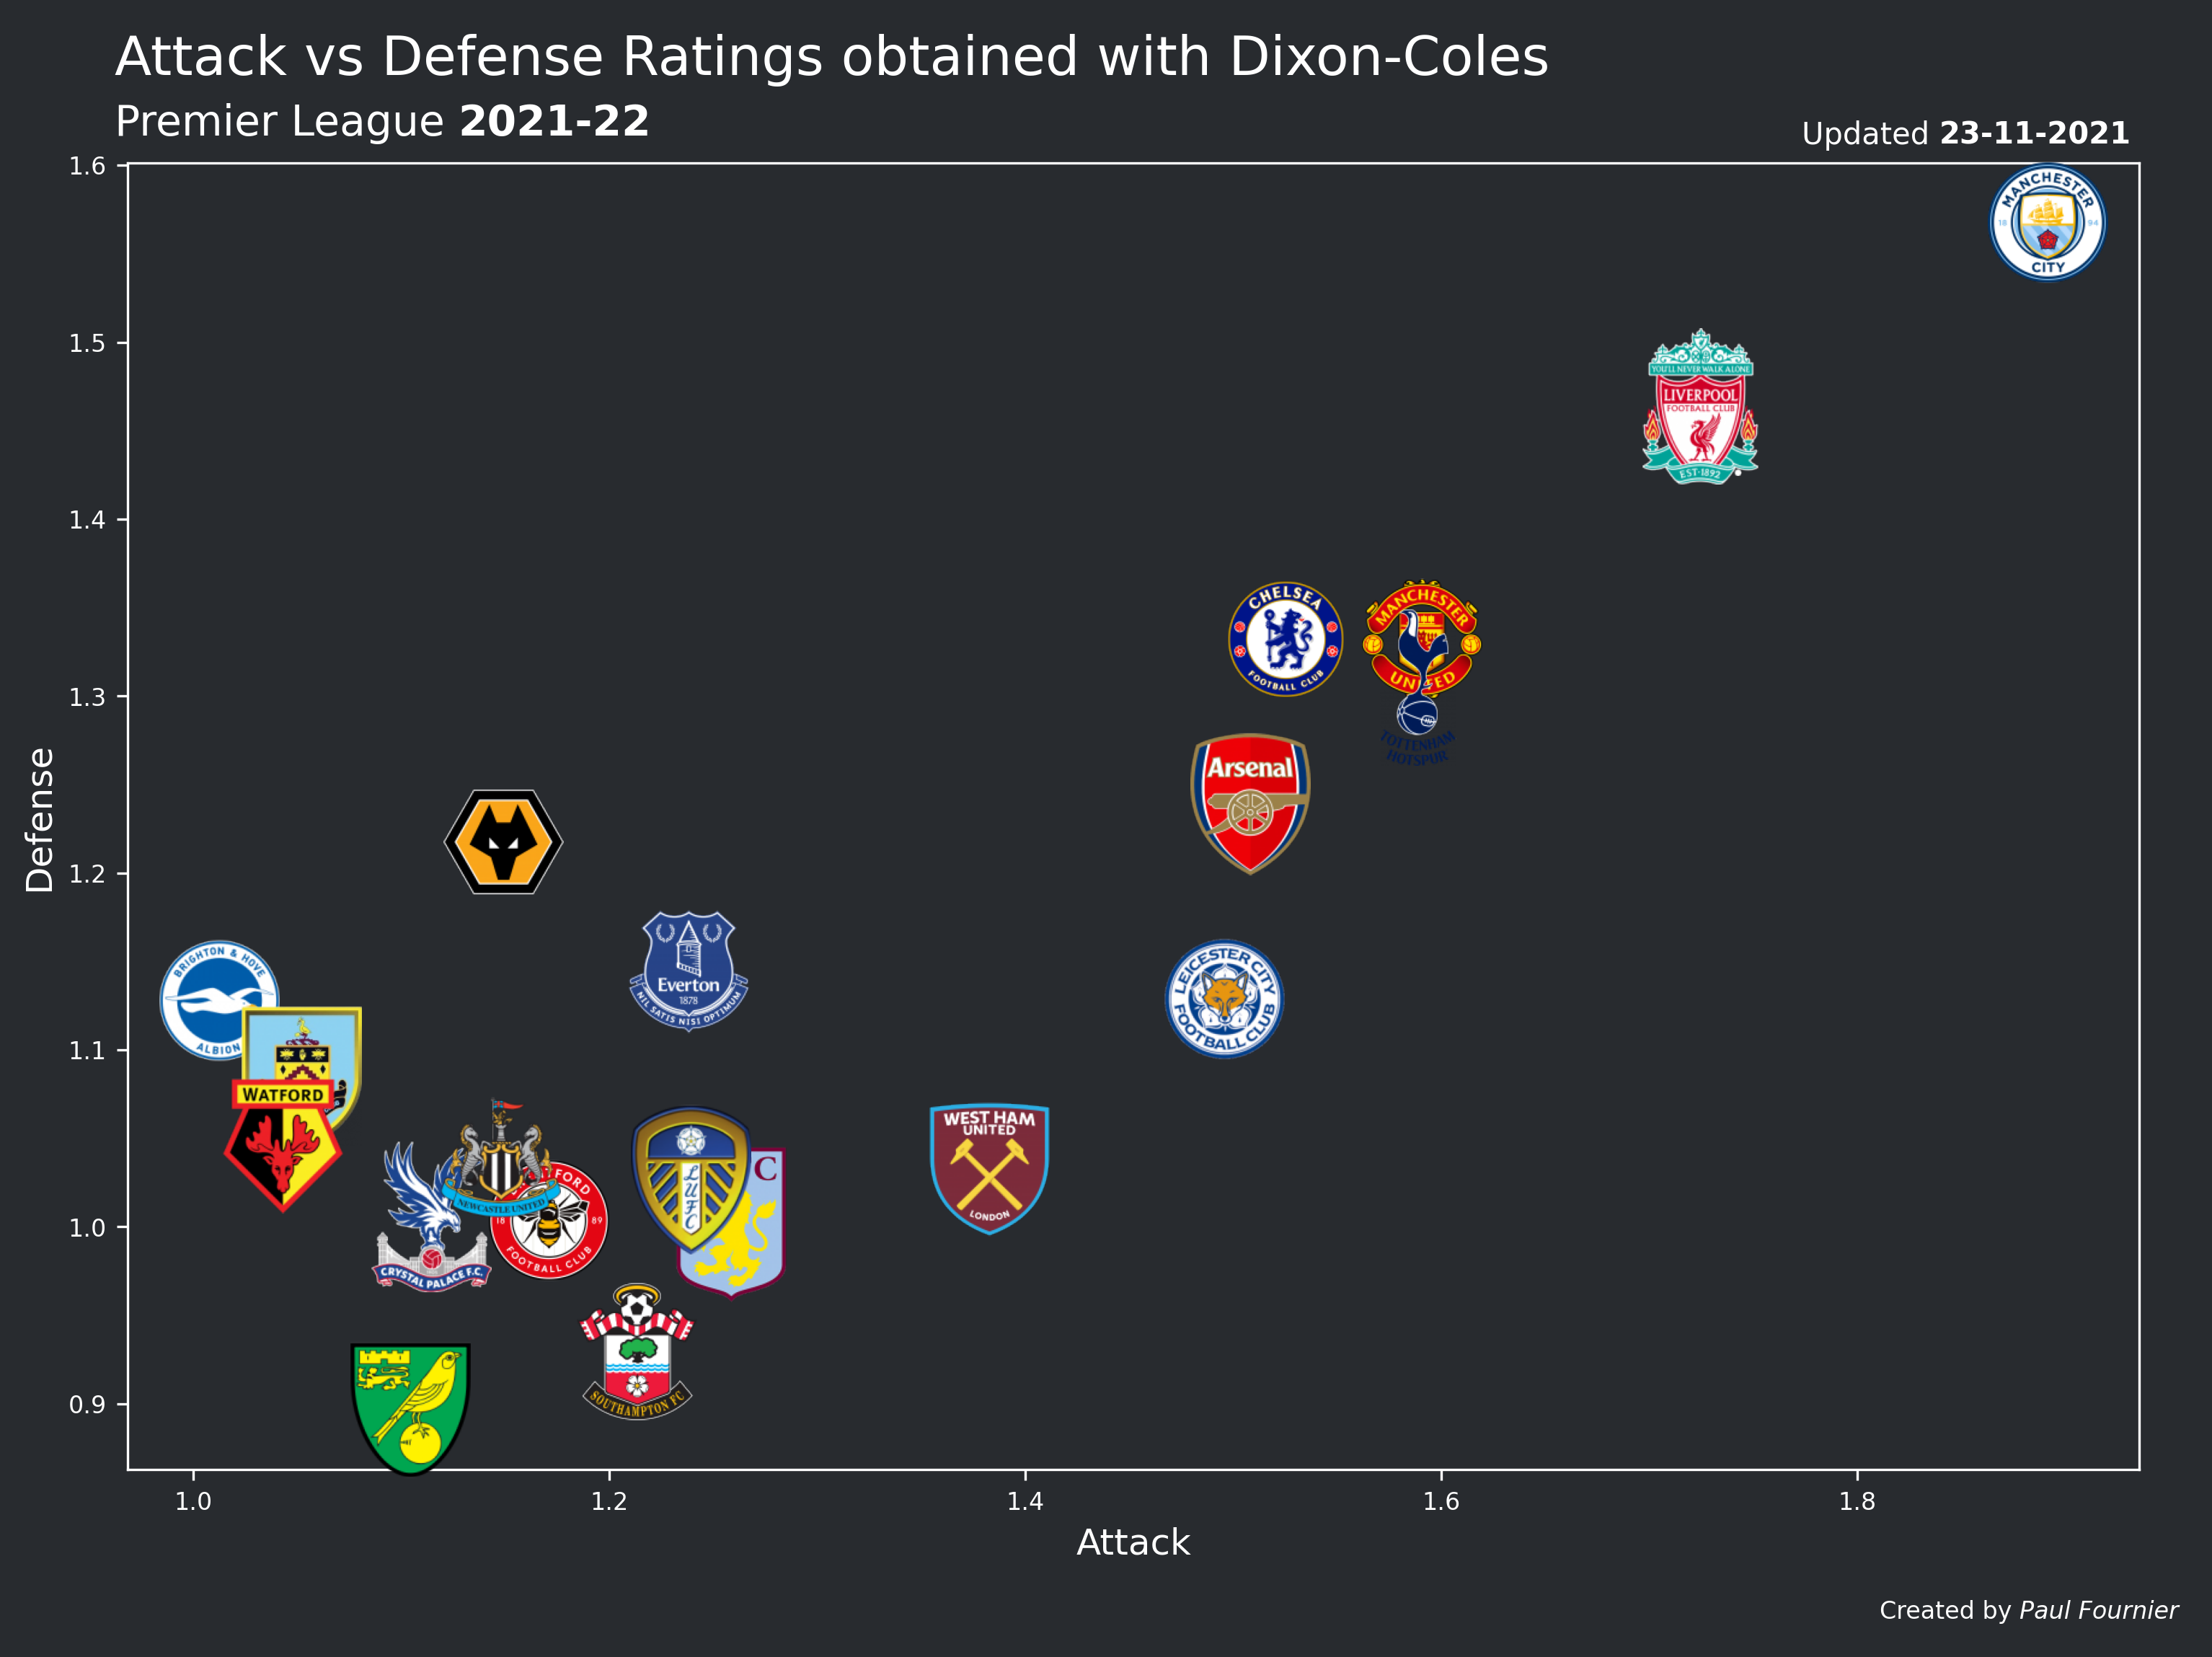

In [6]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path):
    return OffsetImage(plt.imread(path), zoom = 0.4)

fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.plot(params.attack, params.defence, 'o')

for label, x, y in zip(params.team, params.attack, params.defence):
    if label in logos.keys():
        ab = AnnotationBbox(
            getImage(logos[label]),
            (x, y),
            frameon=False)
        ax.add_artist(ab)

fig_text(
    x=0.12, y=0.955,
    s="Attack vs Defense Ratings obtained with <Dixon-Coles>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=18, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.12, y=0.915,
    s="Premier League <2021-22>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=14, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.77, y=0.905,
    s="Updated <23-11-2021>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=10, fontfamily=title_font, color=text_color, alpha=1)

fig_text(
    x=0.8, y=0.05,
    s="Created by <Paul Fournier>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=8, fontfamily=watermark_font, color=text_color)

ax.set_xlabel('Attack', fontsize=12, color=text_color)
ax.set_ylabel('Defense' , fontsize=12, color=text_color)

plt.show()

## Bayesian XG

In [7]:
from bayesian_xg import Bayesian_XG

df = pd.read_csv("../data/fivethirtyeight/spi_matches.csv")
df = (df
    .loc[(df['league_id'] == 2411) | (df['league_id'] == 2412)]
    .dropna()
    )

model = Bayesian_XG(df[df['season'] != 2021], 0.0001)
model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [def_star, tau_def, atts_star, tau_att, intercept, home]


Sampling 2 chains for 1_000 tune and 810 draw iterations (2_000 + 1_620 draws total) took 17 seconds.


In [ ]:
parameter_df = (
    pd.DataFrame()
    .assign(
        attack=[np.mean([x[team] for x in model.trace["atts"]])
        for team in range(model.league_size)])
    .assign(
        defence=[np.mean([x[team] for x in model.trace["defs"]])
        for team in range(model.league_size)])
    .assign(team=np.array(model.teams.team_index.values))
)

aggregate_df = (
    model.games.loc[:, ["team1", "hg"]]
    .drop_duplicates()
    .merge(parameter_df, left_on='hg', right_on='team')
    .assign(home_adv=np.mean(model.trace["home"]))
    .assign(intercept=np.mean([x for x in model.trace["intercept"]]))
    .drop(["hg", "team"], axis=1)
)
aggregate_df.sort_values('attack', ascending=False).head()

In [ ]:
aggregate_df = aggregate_df[aggregate_df.team1.isin([k for k in logos.keys()])]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.plot(aggregate_df.attack, aggregate_df.defence, 'o')

for label, x, y in zip(
        aggregate_df.team1, aggregate_df.attack, aggregate_df.defence):
    if label in logos.keys():
        ab = AnnotationBbox(
            getImage(logos[label]),
            (x, y),
            frameon=False)
        ax.add_artist(ab)

fig_text(
    x=0.12, y=0.955,
    s="Attack vs Defense Ratings obtained with a <Bayesian Model>",
    fontsize=18, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.12, y=0.915,
    s="Premier League <2021-22>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=14, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.77, y=0.905,
    s="Updated <23-11-2021>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=10, fontfamily=title_font, color=text_color, alpha=1)

fig_text(
    x=0.8, y=0.05,
    s="Created by <Paul Fournier>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=8, fontfamily=watermark_font, color=text_color)
fig_text(
    x=0.8, y=0.03,
    s="Data from <FiveThirtyEight>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=8, fontfamily=watermark_font, color=text_color)

ax.set_xlabel('Attack', fontsize=12, color=text_color)
ax.set_ylabel('Defense' , fontsize=12, color=text_color)
ax.invert_yaxis()

plt.show()

In [ ]:
import arviz as az

atts = (
    pd.DataFrame(az.stats.hdi(model.trace["atts"]), columns=["lower_hdi", "upper_hdi"])
    .assign(median=np.quantile(model.trace["atts"], 0.5, axis=0))
    .merge(model.teams, left_index=True, right_on="team_index")
    .drop(["team_index"], axis=1)
    .rename(columns={"team": "Team"})
    .assign(lower=lambda x: x["median"] - x["lower_hdi"])
    .assign(upper=lambda x: x["upper_hdi"] - x["median"])
    .sort_values("median", ascending=True)
)
atts = atts[atts.Team.isin([k for k in logos.keys()])]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor(background)
ax.patch.set_alpha(0)

fig_text(
    x=0.12, y=0.955,
    s="Highest Posterior Density Interval for the Attack Parameter",
    fontsize=18, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.12, y=0.915,
    s="Premier League <2021-22>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=14, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.77, y=0.905,
    s="Updated <23-11-2021>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=10, fontfamily=title_font, color=text_color, alpha=1)

fig_text(
    x=0.8, y=0.05,
    s="Created by <Paul Fournier>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=8, fontfamily=watermark_font, color=text_color)
fig_text(
    x=0.8, y=0.03,
    s="Data from <FiveThirtyEight>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=8, fontfamily=watermark_font, color=text_color)

ax.set_ylabel('Attack' , fontsize=12, color=text_color)

def get_logo(name):
    return plt.imread(logos[name])

def offset_image(coord, name, ax):
    img = get_logo(name)
    im = OffsetImage(img, zoom=0.25)
    im.image.axes = ax

    ab = AnnotationBbox(
        im,
        ((coord+1)/21, -0.05),
        frameon=False,
        xycoords='axes fraction')

    ax.add_artist(ab)

for i, c in enumerate(atts.Team):
    offset_image(i, c, ax)

ax.errorbar(
    atts["Team"],
    atts["median"],
    yerr=(atts[["lower", "upper"]].values).T,
    fmt="o",
    ecolor='#815ac0',
    elinewidth=2,
    markeredgecolor='#a06cd5',
    markerfacecolor='#a06cd5',
    ms=5
    )
plt.gca().axes.get_xaxis().set_visible(False)

In [ ]:
defs = (
    pd.DataFrame(az.stats.hdi(model.trace["defs"]), columns=["lower_hdi", "upper_hdi"])
    .assign(median=np.quantile(model.trace["defs"], 0.5, axis=0))
    .merge(model.teams, left_index=True, right_on="team_index")
    .drop(["team_index"], axis=1)
    .rename(columns={"team": "Team"})
    .assign(lower=lambda x: x["median"] - x["lower_hdi"])
    .assign(upper=lambda x: x["upper_hdi"] - x["median"])
    .sort_values("median", ascending=True)
)
defs = defs[defs.Team.isin([k for k in logos.keys()])]

fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor(background)
ax.patch.set_alpha(0)

fig_text(
    x=0.12, y=0.955,
    s="Highest Posterior Density Interval for the Defense Parameter",
    fontsize=18, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.12, y=0.915,
    s="Premier League <2021-22>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=14, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.77, y=0.905,
    s="Updated <23-11-2021>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=10, fontfamily=title_font, color=text_color, alpha=1)

fig_text(
    x=0.8, y=0.05,
    s="Created by <Paul Fournier>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=8, fontfamily=watermark_font, color=text_color)
fig_text(
    x=0.8, y=0.03,
    s="Data from <FiveThirtyEight>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=8, fontfamily=watermark_font, color=text_color)
ax.set_ylabel('Defense' , fontsize=12, color=text_color)

for i, c in enumerate(defs.Team):
    offset_image(i, c, ax)

ax.errorbar(
    defs["Team"],
    defs["median"],
    yerr=(defs[["lower", "upper"]].values).T,
    fmt="o",
    ecolor='#815ac0',
    elinewidth=2,
    markeredgecolor='#a06cd5',
    markerfacecolor='#a06cd5',
    ms=5
    )
ax.invert_yaxis()

plt.gca().axes.get_xaxis().set_visible(False)

## Elo

In [8]:
colors = {
    # https://teamcolorcodes.com/soccer/premier-league-color-codes/
    'Arsenal': '#EF0107',
    'Aston Villa': '#95bfe5',
    'Brighton': '#0057B8',
    'Brentford': '#DA291C',
    'Burnley': '#6C1D45',
    'Chelsea': '#034694',
    'Crystal Palace': '#1B458F',
    'Everton': '#003399',
    'Leicester': '#003090',
    'Leeds': '#FFCD00',
    'Liverpool': '#c8102E',
    'Man City': '#6CABDD',
    'Man United': '#DA291C',
    'Norwich': '#FFF200',
    'Newcastle': '#241F20',
    'Southampton': '#d71920',
    'Tottenham': '#132257',
    'Watford': '#FBEE23',
    'West Ham': '#7A263A',
    'Wolves': '#FDB913'
}

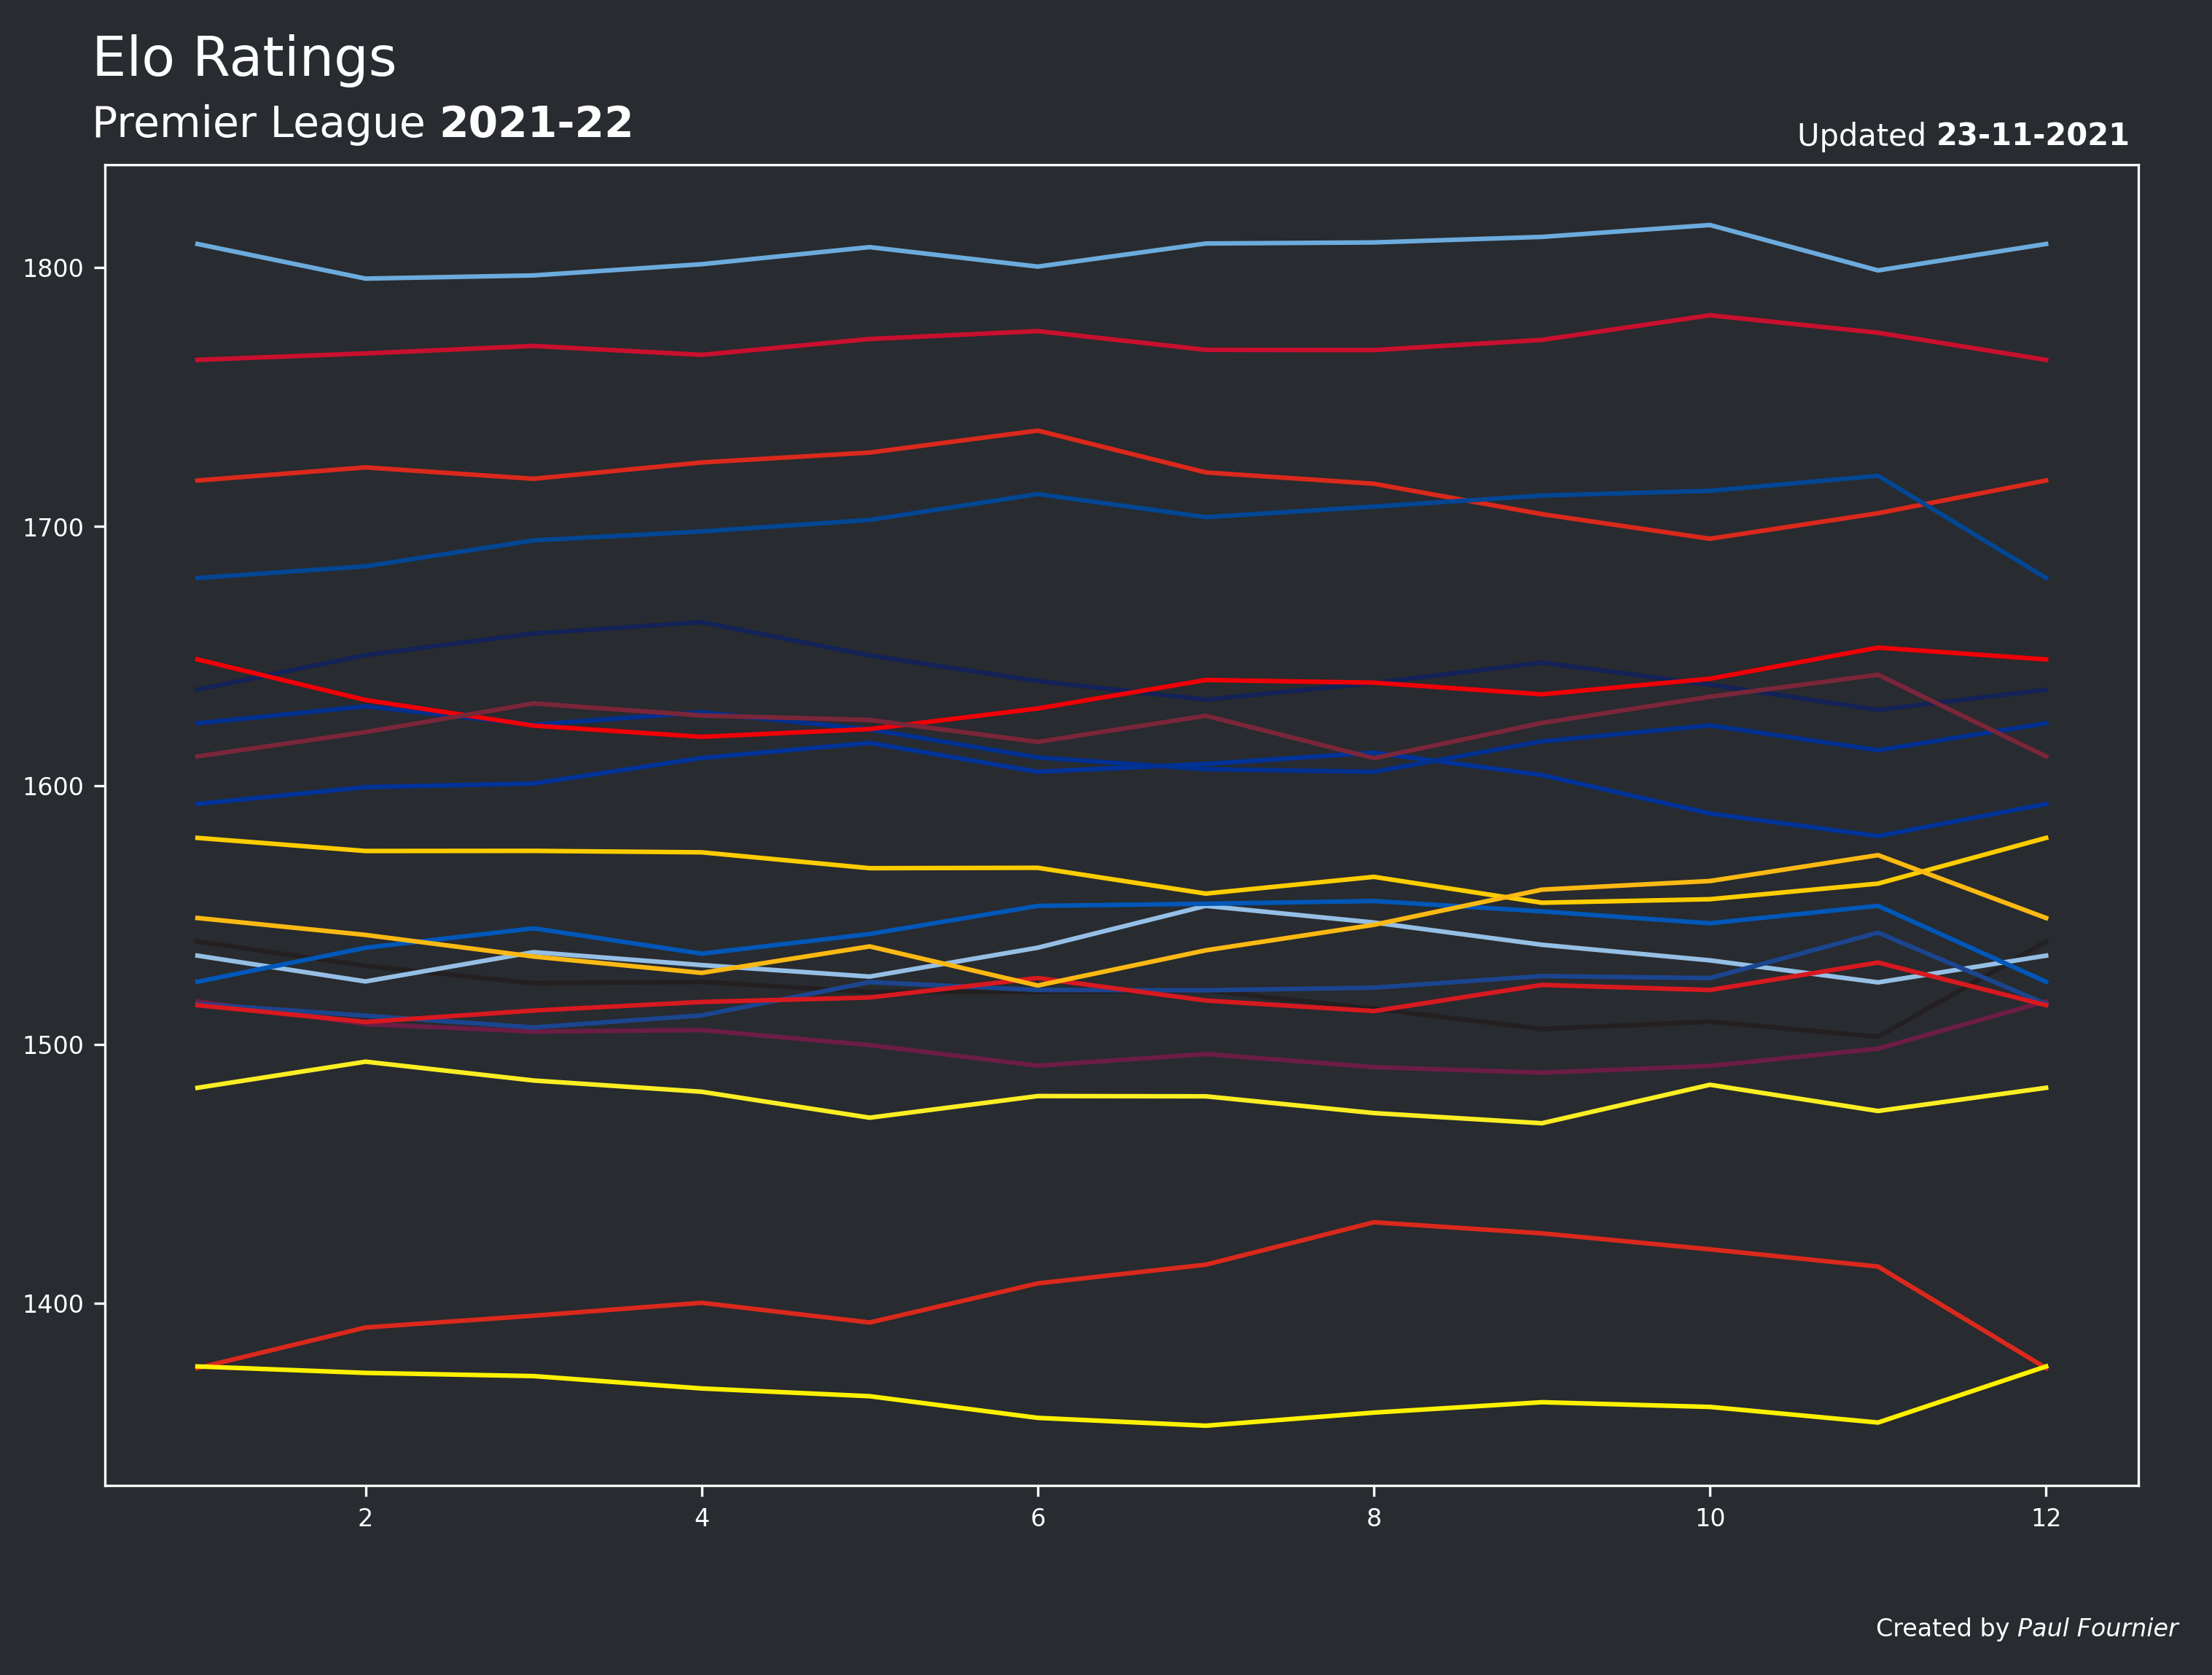

In [9]:
df = pd.read_csv("../data/predictions/scores/elo.csv")

fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor(background)
ax.patch.set_alpha(0)

for team in df.team1.unique():
    elo = (
        pd.concat([
            df
            .loc[df.team1 == team]
            .loc[:, ['date', 'team1', 'event', 'home_rating']]
            .rename(columns={
                'home_rating': 'rating',
                'team1': 'team',
                }),
            df
            .loc[df.team2 == team]
            .loc[:, ['date', 'team2', 'event', 'away_rating']]
            .rename(columns={
                'away_rating': 'rating',
                'team2': 'team',
                })
        ]).sort_values("event")
    )
    ax.plot(elo.event, elo.rating, color=colors[team])

fig_text(
    x=0.12, y=0.955,
    s="Elo Ratings",
    fontsize=18, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.12, y=0.915,
    s="Premier League <2021-22>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=14, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.77, y=0.905,
    s="Updated <23-11-2021>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=10, fontfamily=title_font, color=text_color, alpha=1)

fig_text(
    x=0.8, y=0.05,
    s="Created by <Paul Fournier>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=8, fontfamily=watermark_font, color=text_color)

plt.show()

## SPI

In [102]:
colors = {
    # https://teamcolorcodes.com/soccer/premier-league-color-codes/
    'Arsenal': '#EF0107',
    'Aston Villa': '#95bfe5',
    'Brighton and Hove Albion': '#0057B8',
    'Brentford': '#DA291C',
    'Burnley': '#6C1D45',
    'Chelsea': '#034694',
    'Crystal Palace': '#1B458F',
    'Everton': '#003399',
    'Leicester City': '#003090',
    'Leeds United': '#FFCD00',
    'Liverpool': '#c8102E',
    'Manchester City': '#6CABDD',
    'Manchester United': '#DA291C',
    'Norwich City': '#FFF200',
    'Newcastle': '#241F20',
    'Southampton': '#d71920',
    'Tottenham Hotspur': '#132257',
    'Watford': '#FBEE23',
    'West Ham United': '#7A263A',
    'Wolverhampton': '#FDB913'
}

In [188]:
df = pd.read_csv("../data/fivethirtyeight/spi_matches.csv")
epl = df.loc[
    (
        df.team1.isin(df.loc[(df.league_id == 2411) & (df.season == 2021)].team1.unique()) |
        df.team2.isin(df.loc[(df.league_id == 2411) & (df.season == 2021)].team1.unique())
        ) &
    (
        (df.league_id == 2411) |
        (df.league_id == 2412)
    )]
epl.date = pd.to_datetime(epl.date)

In [189]:
import datetime

base = epl.date.min()
spis = pd.DataFrame(
    {
        "date": [
            base + datetime.timedelta(days=x) 
            for x in range((epl.date.max() - epl.date.min()).days)
    ]})

In [190]:
for team in df.loc[
        (df.league_id == 2411) & (df.season == 2021)].team1.unique():
    # Get the SPI Ratings as time series
    team_spi = pd.concat([
        epl
        .loc[epl.team1 == team]
        .loc[:, ['date', 'team1', 'spi1']]
        .rename(columns={
            'spi1': 'rating',
            'team1': 'team',
            }),
        epl
        .loc[epl.team2 == team]
        .loc[:, ['date', 'team2', 'spi2']]
        .rename(columns={
            'spi2': 'rating',
            'team2': 'team',
            })
    ]).sort_values("date")
    team_spi.date = pd.to_datetime(team_spi.date)
    team_spi[team] = team_spi.rating

    spis = pd.merge(
        spis,
        team_spi.loc[:, ['date', team]],
        left_on="date",
        right_on="date",
        how='outer'
        )

    # Forward filling
    spis[team] = spis[team].pad()

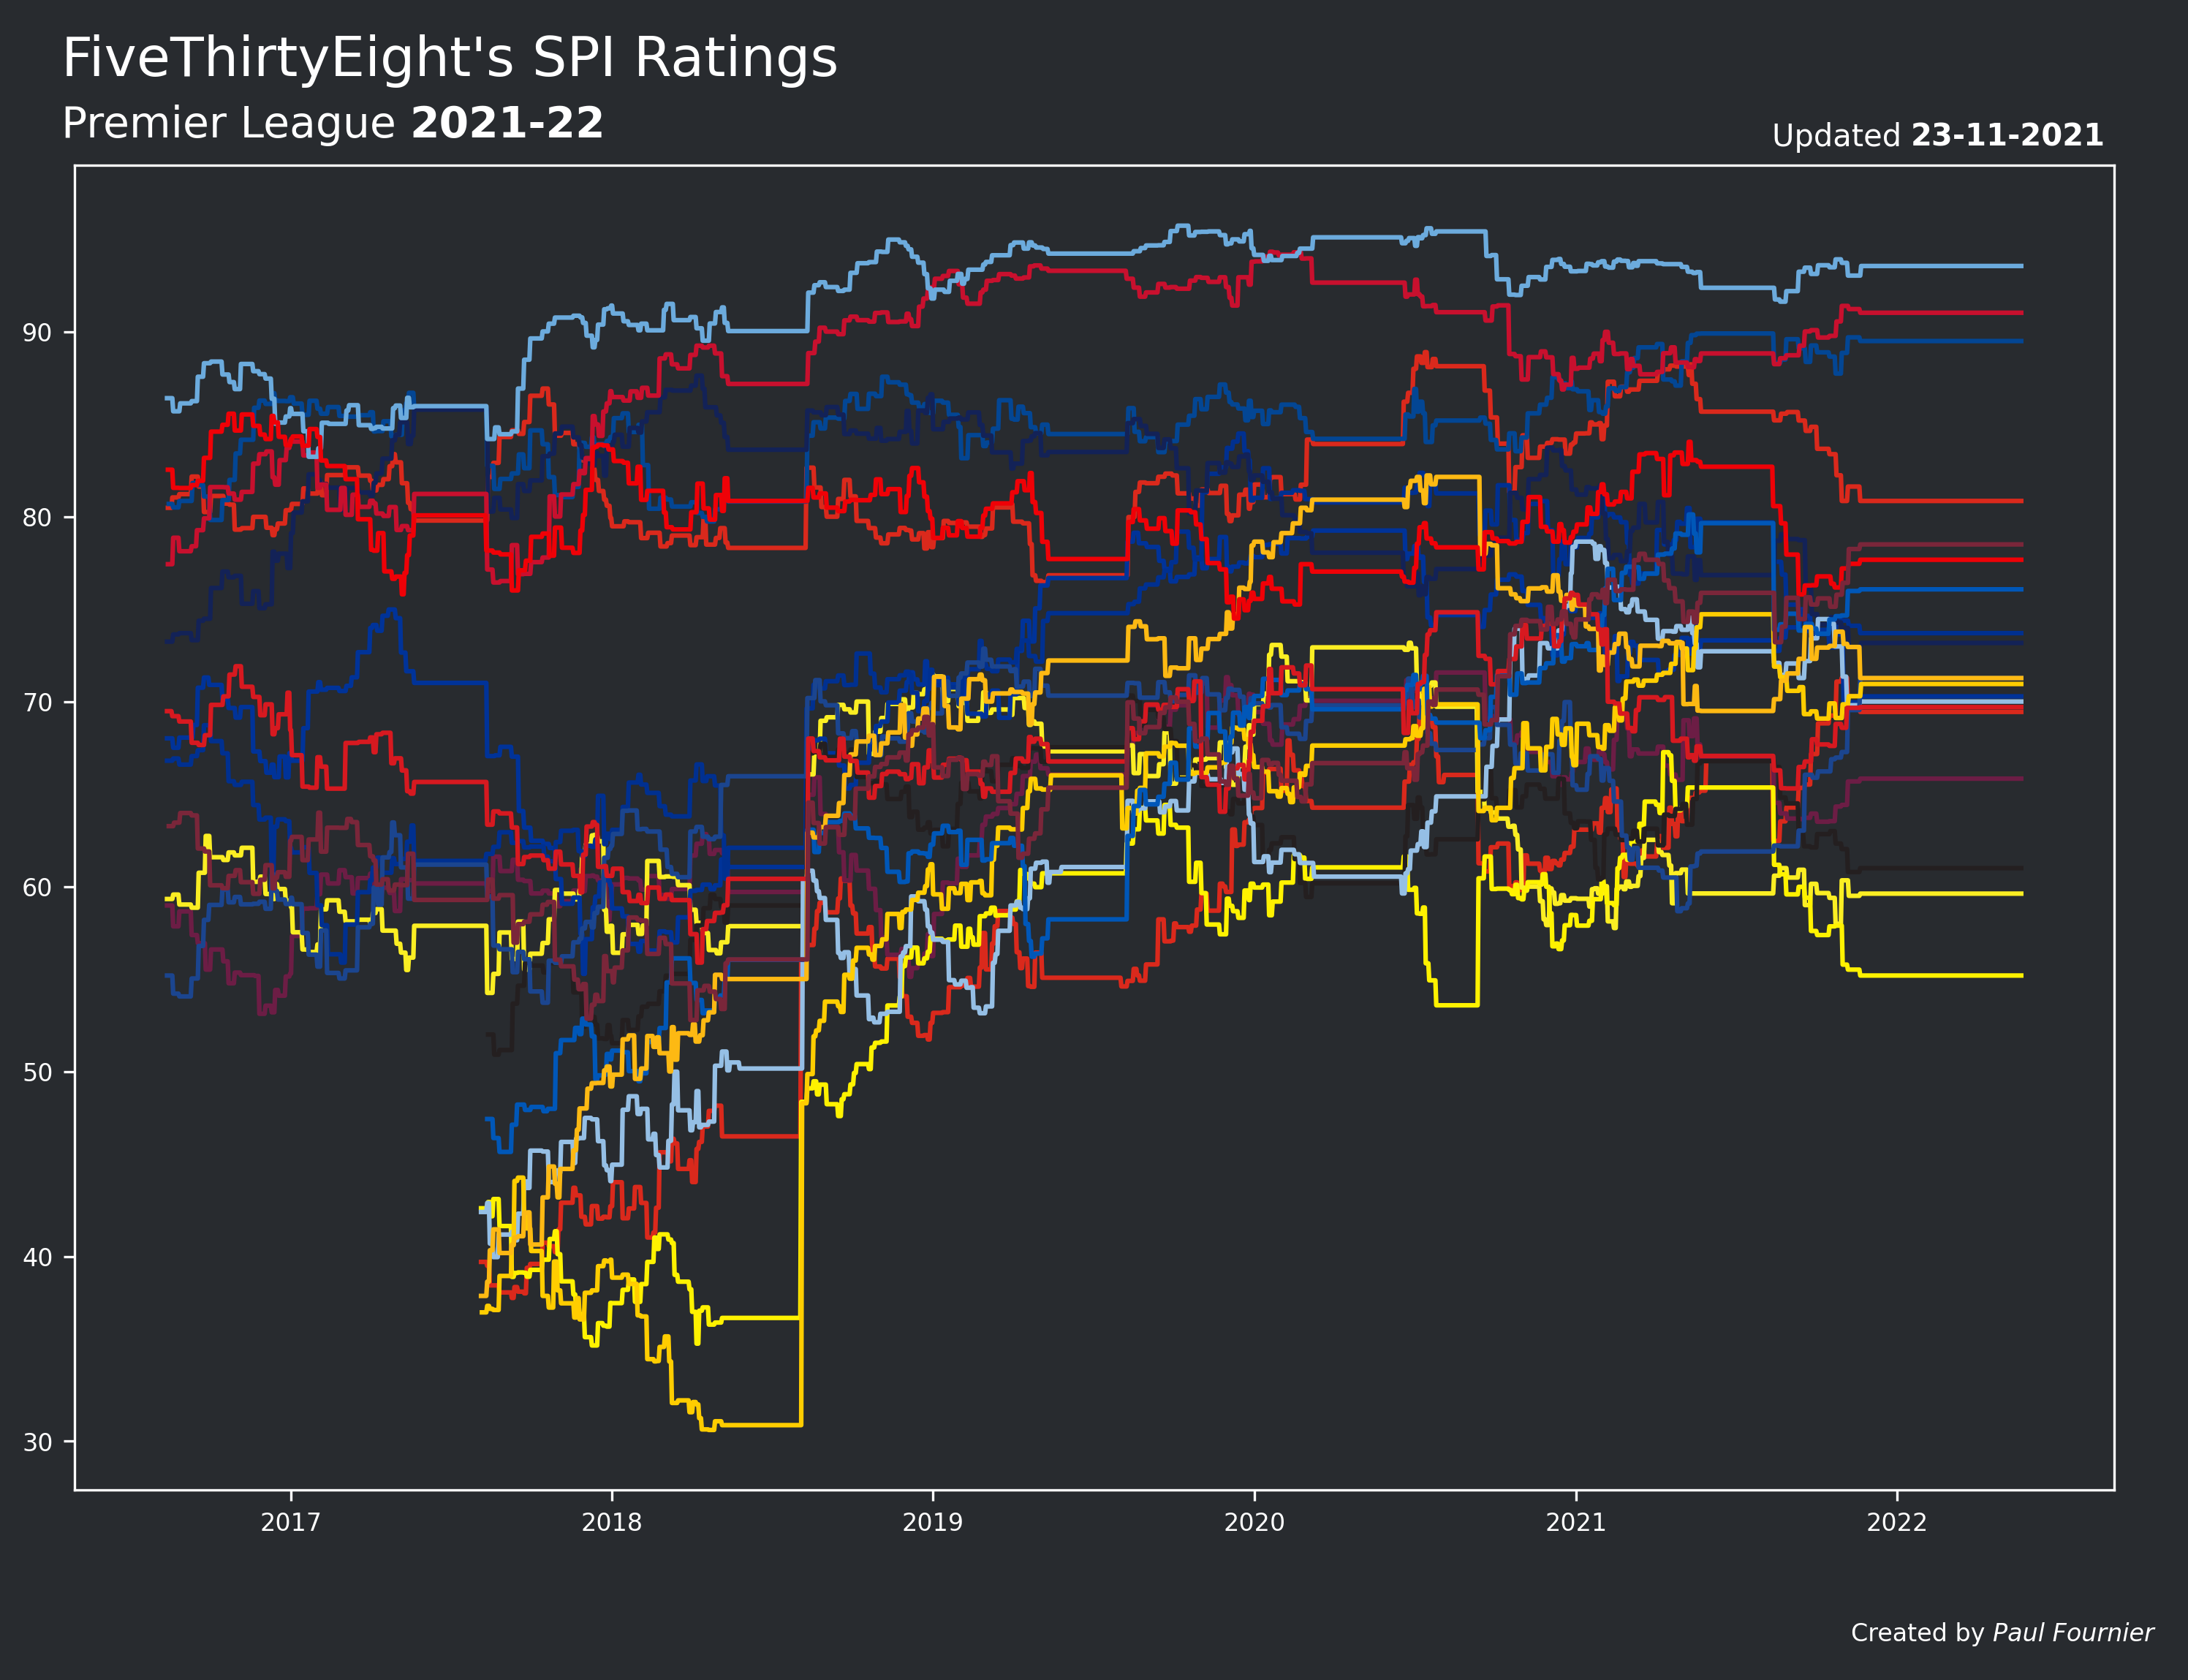

In [193]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor(background)
ax.patch.set_alpha(0)

for team in df.loc[(df.league_id == 2411) & (df.season == 2021)].team1.unique():
    ax.plot(spis.date, spis[team], color=colors[team], label=team)

fig_text(
    x=0.12, y=0.955,
    s="FiveThirtyEight's SPI Ratings",
    fontsize=18, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.12, y=0.915,
    s="Premier League <2021-22>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=14, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.77, y=0.905,
    s="Updated <23-11-2021>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=10, fontfamily=title_font, color=text_color, alpha=1)

fig_text(
    x=0.8, y=0.05,
    s="Created by <Paul Fournier>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=8, fontfamily=watermark_font, color=text_color)

plt.show()